# Check Vacuum Equilibria for Islands via Field Line Tracing

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

In [2]:
from desc import set_device
set_device("gpu")

In [3]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

I like to have this import all for convenience,

In [4]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic

print_backend_info()

DESC version=0.16.0+431.g27a83e1ba.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 10.92 GB available memory.


In [ ]:
def plot_field_lines(field, equ, ntransit=200, nrho=9, size=0.4, outside=False):
    """Plots DESC surfaces and the Poincare plot on the same ax."""
    # for starting locations we'll pick positions on flux surfaces on the outboard midplane
    if outside:
        grid_trace = LinearGrid(rho=np.linspace(0, 1, 2))
        r0 = equ.compute("R", grid=grid_trace)["R"]
        z0 = equ.compute("Z", grid=grid_trace)["Z"]
        rmax = np.max(r0)
        rmin = np.min(r0)
        r0 = np.linspace(rmin, rmax + (rmax-rmin)*0.05, nrho)
        z0 = np.zeros_like(r0)
    else:
        grid_trace = LinearGrid(rho=np.linspace(0, 1, nrho))
        r0 = equ.compute("R", grid=grid_trace)["R"]
        z0 = equ.compute("Z", grid=grid_trace)["Z"]
    fig, ax = plot_surfaces(equ)
    fig, ax = poincare_plot(
        field,
        r0,
        z0,
        NFP=equ.NFP,
        ax=ax,
        color="k",
        size=size,
        ntransit=ntransit,
        bounds_R=(0.5, 1.5),
        bounds_Z=(-0.7, 0.7),
    )
    return fig, ax

In [19]:
def optimize_coils_regcoil(surf, equ, num_coils=16, return_k=False):
    """Gets the surface current K."""
    # create the FourierCurrentPotentialField object from the constant offset surface we found in the previous cell
    surface_current_field = FourierCurrentPotentialField.from_surface(
        surf,
        I=0,
        # manually setting G to value needed to provide the equilibrium's toroidal flux,
        # though this is not necessary as it gets set automatically inside the solve_regularized_surface_current function
        G=np.asarray(
            [
                -equ.compute("G", grid=LinearGrid(rho=np.array(1.0)))["G"][0]
                / mu_0
                * 2
                * np.pi
            ]
        ),
        # set symmetry of the current potential, "sin" is usually expected for stellarator-symmetric surfaces and equilibria
        sym_Phi="sin",
    )

    surface_current_field.change_Phi_resolution(M=12, N=12)

    # create the evaluation grid (where Bn will be minimized on plasma surface)
    # and source grid (discretizes the source K for Biot-Savart and where |K| will be penalized on winding surface)
    Megrid = 20
    Negrid = 20
    Msgrid = 20
    Nsgrid = 20

    eval_grid = LinearGrid(M=Megrid, N=Negrid, NFP=equ.NFP, sym=False)
    # ensure that sym=False for source grid so the field evaluated from the surface current is accurate
    # (i.e. must evaluate source over whole surface, not just the symmetric part)
    # NFP>1 is ok, as we internally will rotate the source through the field periods to sample entire winding surface
    sgrid = LinearGrid(M=Msgrid, N=Nsgrid, NFP=equ.NFP, sym=False)

    lambda_regularization = np.append(np.array([0]), np.logspace(-30, 1, 20))

    # solve_regularized_surface_current method runs the REGCOIL algorithm
    fields, data = solve_regularized_surface_current(
        surface_current_field,  # the surface current field whose geometry and Phi resolution will be used
        eq=equ,  # the Equilibrium object to minimize Bn on the surface of
        source_grid=sgrid,  # source grid
        eval_grid=eval_grid,  # evaluation grid
        current_helicity=(
            1*surface_current_field.NFP,
            -1,
        ),  # pair of integers (M_coil, N_coil), determines topology of contours (almost like  QS helicity),
        #  M_coil is the number of times the coil transits poloidally before closing back on itself
        # and N_coil is the toroidal analog (if M_coil!=0 and N_coil=0, we have modular coils, if both M_coil
        # and N_coil are nonzero, we have helical coils)
        # we pass in an array to perform scan over the regularization parameter (which we call lambda_regularization)
        # to see tradeoff between Bn and current complexity
        lambda_regularization=lambda_regularization,
        # lambda_regularization can also be just a single number in which case no scan is performed
        vacuum=True,  # this is a vacuum equilibrium, so no need to calculate the Bn contribution from the plasma currents
        regularization_type="regcoil",
        chunk_size=40,
    )
    surface_current_field = fields[
        0
    ]  # fields is a list of FourierCurrentPotentialField objects

    if return_k:
        return surface_current_field
    else:
        coilset = surface_current_field.to_CoilSet(num_coils=num_coils, stell_sym=True)
        return coilset

# Get Equilibria

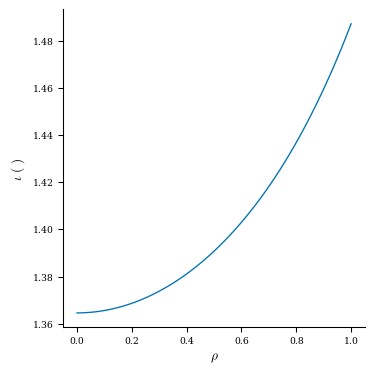

In [14]:
eq = desc.io.load("eqfam_rotated_poincare_optimize_QH_wqs1.0_war50.0_wvol150.0.h5")[-1]
plot_1d(eq, "iota");

In [ ]:
# create the constant offset surface
surf = eq.surface.constant_offset_surface(
    offset=0.25,  # desired offset
    M=16,  # Poloidal resolution of desired offset surface
    N=16,  # Toroidal resolution of desired offset surface
    grid=LinearGrid(M=32, N=32, NFP=eq.NFP),
)  # grid of points on base surface to evaluate unit normal and find points on offset surface,
# generally should be twice the desired resolution
optimized_K = optimize_coils_regcoil(
    surf, eq, return_k=True
)

##########################################################
Calculating Phi_SV for lambda_regularization = 0.00000e+00
##########################################################
chi^2 B = 7.70167e-08
min Bnormal = 4.92189e-17 (T)
Max Bnormal = 1.93524e-06 (T)
Avg Bnormal = 3.23343e-07 (T)
min Bnormal = 4.13915e-17 (unitless)
Max Bnormal = 1.62747e-06 (unitless)
Avg Bnormal = 2.71921e-07 (unitless)
##########################################################
Calculating Phi_SV for lambda_regularization = 1.00000e-30
##########################################################
chi^2 B = 7.70300e-08
min Bnormal = 5.99963e-17 (T)
Max Bnormal = 1.93371e-06 (T)
Avg Bnormal = 3.23296e-07 (T)
min Bnormal = 5.04550e-17 (unitless)
Max Bnormal = 1.62619e-06 (unitless)
Avg Bnormal = 2.71881e-07 (unitless)
##########################################################
Calculating Phi_SV for lambda_regularization = 4.28133e-29
##########################################################
chi^2 B = 7.86501e-08
m

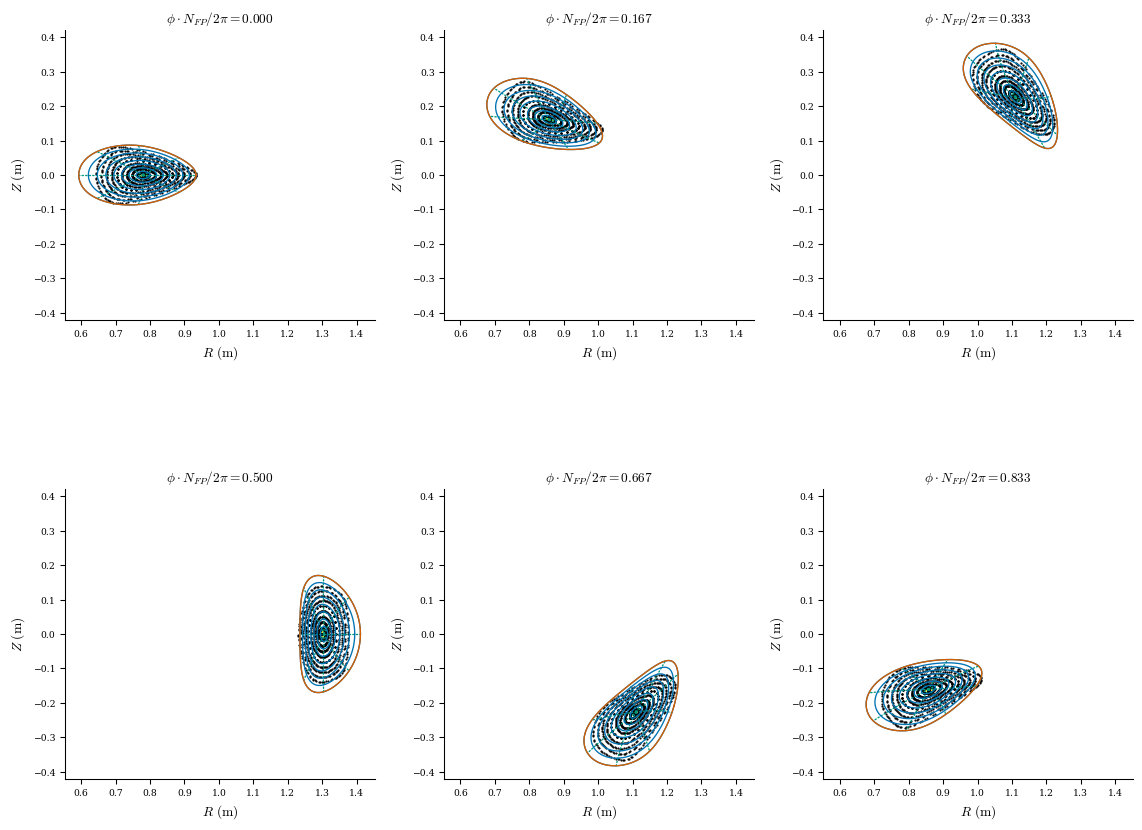

In [16]:
fig, ax = plot_field_lines(
    optimized_K, eq, nrho=10, ntransit=100, outside=False
)
plt.show()

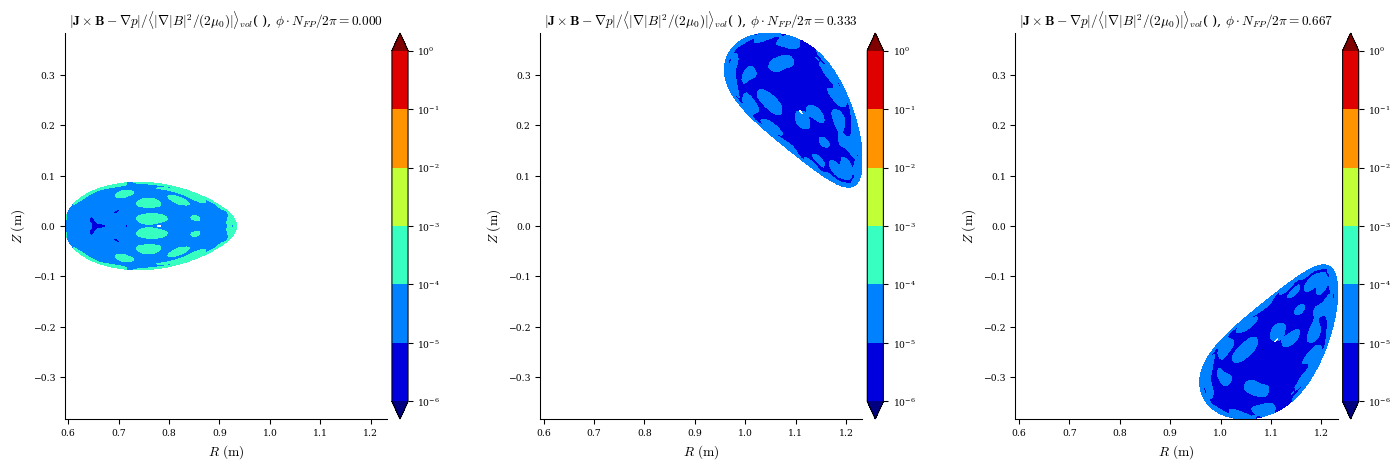

In [17]:
levels = np.logspace(-6,0, 7)
plot_section(eq, "|F|_normalized", phi=3, log=True, levels=levels);